In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [3]:
from analyse import analysis_WSLS_v1
from simulate import (
    simulate_M1random_v1,
    simulate_M2WSLS_v1,
    simulate_M3RescorlaWagner_v1,
    simulate_M4ChoiceKernel_v1,
    simulate_M5RWCK_v1
)

In [4]:
# experiment parameters
T = 100
mu = np.array([0.2, 0.8])

# number of repetitions for simulations
Nrep = 110


sim = {}
for i in range(1, 6):
    sim[i] = {
        'a': np.zeros((T, Nrep)),
        'r': np.zeros((T, Nrep))}
    
# Model 1: Random responding
for n in range(Nrep):
    b = 0.5
    a, r = simulate_M1random_v1(T, mu, b)
    sim[1]['a'][:, n] = a 
    sim[1]['r'][:, n] = r 
    
# Model 2: Win-stay-lose-shift

for n in range(Nrep):
    epsilon = 0.1
    a, r = simulate_M2WSLS_v1(T, mu, epsilon)
    sim[2]['a'][:, n] = a 
    sim[2]['r'][:, n] = r 
    
# Model 3: Rescorla Wagner
for n in range(Nrep):
    alpha = 0.1
    beta = 5
    a, r = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta)
    sim[3]['a'][:, n] = a 
    sim[3]['r'][:, n] = r 
    
# Model 4: Choice kernel
for n in range(Nrep):
    alpha_c = 0.1
    beta_c = 3
    a, r = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c)
    sim[4]['a'][:, n] = a 
    sim[4]['r'][:, n] = r 

# Model 5: Rescorla-Wagner + choice kernel
for n in range(Nrep):
    alpha = 0.1
    beta = 5
    alpha_c = 0.1
    beta_c = 1
    a, r = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c)
    sim[5]['a'][:, n] = a 
    sim[5]['r'][:, n] = r 

# win-stay-lose-shift analysis
wsls = {}
for i in sim:
    sim[i]['wsls'] = np.zeros((2, Nrep))
    for n in range(Nrep):
        sim[i]['wsls'][:,n] = analysis_WSLS_v1(
            sim[i]['a'][:, n].T, sim[i]['r'][:, n].T)
   
    wsls[i] = np.nanmean(sim[i]['wsls'],axis=1)

In [5]:
## function for plotting WSLS behavior for all models
def plot_WSLS(wsls, ax):
    labels = ['M1: random', 'M2: WSLS', 'M3: RW', 'M4: CK', 'M5: RW+CK']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, j in enumerate(wsls):
        ax.plot(wsls[j], marker='o', label=labels[i])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['0', '0.5', '1'])
    ax.set_ylabel('Probability of staying')
    ax.set_xlabel('Previous reward')
    ax.set_title('stay behaviour')


In [6]:
## p(correct) analysis

alphas = np.arange(0.02, 1 + 0.02, 0.02)
betas = np.array([1, 2, 5, 10, 20])

# 1000 simulations takes a long time
N = 1000
bar = IntProgress(min=0, max=N)
display(bar)

shape = (len(alphas), len(betas), N,)
correct = np.zeros(shape)
correctEarly = np.zeros(shape)
correctLate = np.zeros(shape)
for n in range(N):
    bar.value = n
    for i in range(len(alphas)):
        for j in range(len(betas)):
            a, r = simulate_M3RescorlaWagner_v1(T, mu, alphas[i], betas[j])
            imax = np.argmax(mu) + 1
            correct[i, j, n] = np.nanmean(a == imax)
            correctEarly[i, j, n] = np.nanmean(a[:10] == imax)
            correctLate[i, j, n] = np.nanmean(a[-10:] == imax)

E = np.nanmean(correctEarly, 2)
L = np.nanmean(correctLate, 2)

IntProgress(value=0, max=1000)

In [7]:
## functions to plot p(correct) behavior


def plot_p_correct_early(ax, X, betas):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for i, beta in enumerate(betas):
        ax.plot(alphas, X[:, i], label =r'$\beta = {}$'.format(beta))

    ax.set_title('early trials')
    ax.set_yticks(np.arange(0.5, 1 + 0.1, 0.1))
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
    ax.set_ylim((0.5, 1.01))
    ax.set_xlabel(r'learning rate, $\alpha$')
    ax.set_ylabel('P(correct)')


def plot_p_correct_late(ax, X, betas):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, beta in enumerate(betas):
        ax.plot(alphas, X[:, i], label=r'$\beta = {}$'.format(beta))
    ax.set_title('late trials')
    ax.set_yticks(np.arange(0.5, 1 + 0.1, 0.1))
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
    ax.set_ylim((0.5, 1.01))
    ax.set_xlabel(r'learning rate, $\alpha$')
    ax.set_ylabel('P(correct)')


In [8]:
# Set up some colors for the plot

AZred = np.array((171, 5, 32)) / 256
AZblue = np.array((12, 35, 75,)) / 256

def linear_colors(start, end, steps):
    colors = []
    for i in range(steps):
        f = i / (steps - 1)
        colors.append(start * (1 - f) + end * f)
    return colors
                      
from cycler import cycler

wsls_colors = cycler('color', [
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
    [0.3010, 0.7450, 0.9330],
    [0.6350, 0.0780, 0.1840],
])                
pcorrect_colors = linear_colors(AZblue, AZred, len(betas))

wsls_prop_cycle = cycler('color', wsls_colors)
pcorrect_prop_cycle = cycler('color', pcorrect_colors)

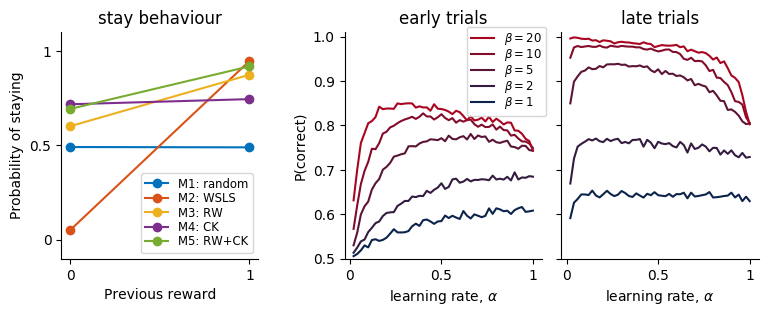

In [11]:
# Actually do the plot.
plt.rcParams['figure.dpi'] = 100


fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, 42)

ax1 = plt.subplot(gs[0, 0:12]) 
ax2 = plt.subplot(gs[0, 17:29])
ax3 = plt.subplot(gs[0, 30:42])

ax1.set_prop_cycle(wsls_prop_cycle)
plot_WSLS(wsls, ax1)
ax1.legend(fontsize='small', labelspacing=0.125)

ax2.set_prop_cycle(pcorrect_prop_cycle)
plot_p_correct_early(ax2, E, betas)
handles, legend = ax2.get_legend_handles_labels()
ax2.legend(
    reversed(handles),
    reversed(legend),
    fontsize='small',
    loc='upper right', 
    bbox_to_anchor=(1.05,1.05), 
    labelspacing=0)

ax3.set_prop_cycle(pcorrect_prop_cycle)
plot_p_correct_late(ax3, L, betas)
ax3.set_yticklabels([])
ax3.set_ylabel('')
None
